In [1]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D ,SeparableConv2D, MaxPooling2D , Input , GlobalAveragePooling2D ,AveragePooling2D, Dense , Dropout ,Activation, Flatten , BatchNormalization, add
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from numpy import loadtxt
from sklearn.metrics import f1_score, recall_score, confusion_matrix, roc_auc_score, average_precision_score
from sklearn.metrics import roc_curve, precision_recall_curve, auc
from sklearn.model_selection import train_test_split
debug = True

all_scores = {}
batch_size = 16
epochs = 30

2024-10-23 03:01:43.152476: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-23 03:01:43.152616: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-23 03:01:43.270210: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
inputs = pd.read_csv("/kaggle/input/amazon-kaggle-with-pca/Amazon_Kaggle_with_PCA.csv", delimiter=',')
outputs = pd.read_csv("/kaggle/input/train-test-amazon1/train_test_amazon1.sample", header = None, delimiter=' ')

In [3]:
inputs = inputs.drop(columns=['Unnamed: 0'])
print(inputs)
outputs = outputs.filter([11])
print(outputs)

              0         1         2         3         4         5         6  \
0      1.770261 -1.259299 -4.137274  0.219519 -2.272145  1.261023 -0.832089   
1      0.111547 -0.923248 -0.515758  0.358302 -0.468171  0.811812  0.583574   
2     -0.795466  0.113435  0.751907 -0.610852  1.150108  0.022268 -1.790796   
3      0.650470 -1.399842 -0.406764 -0.761072  0.248319 -0.067045 -1.038479   
4      1.513254 -0.368222 -0.461411 -0.338803 -0.110288  1.393196  0.088838   
...         ...       ...       ...       ...       ...       ...       ...   
32764  0.038324  0.608743  0.115501 -1.488739 -0.116374  0.335744 -0.894558   
32765 -0.386422  0.182174  1.162071 -0.652403  1.066914  0.587248 -1.537257   
32766  0.402048 -0.377368  0.286475 -0.059459 -0.857581 -2.173894 -0.101953   
32767 -1.283080  0.669593  0.746969 -0.147694  0.276069 -0.065078 -0.724832   
32768 -0.971727  0.479671 -0.576030  0.195303 -0.891990  0.574659  0.807037   

              7         8         9        10  
0  

In [4]:
x_ = inputs
y_ = outputs
x_train, x_test, y_train, y_test = train_test_split(x_, y_, test_size=0.2, random_state=42)

# Reshape input data
x_train = x_train.values.reshape(-1, x_train.shape[1], 1, 1)
x_test = x_test.values.reshape(-1, x_test.shape[1], 1, 1)

if debug:
    print('shape of x_train after reshaping', x_train.shape)
    print('shape of x_test after reshaping', x_test.shape)

#determine batch size
batch_size = min(x_train.shape[0] / 10, batch_size)
if debug:
    print('batch size: ' + str(batch_size))

# Modify input shape accordingly
input_shape = (x_train.shape[1], 1, 1)
# Create the input layer
inputs = Input(shape=input_shape)

# Entry Flow
x = Conv2D(32, (3, 3), strides=(2, 2), padding='same')(inputs)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2D(64, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

previous_block_activation = x
for size in [128, 256, 728]:
    x = Activation('relu')(x)
    x = Conv2D(size, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)

    x = Activation('relu')(x)
    x = Conv2D(size, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    residual = Conv2D(size, (1, 1), strides=(2, 2), padding='same')(previous_block_activation)
    x = add([x, residual])
    previous_block_activation = x

def middle_flow(x, num_blocks=8):
    previous_block_activation = x

    for _ in range(num_blocks):
        x = Activation('relu')(x)
        x = SeparableConv2D(728, 3, padding='same')(x)
        x = BatchNormalization()(x)

        x = Activation('relu')(x)
        x = SeparableConv2D(728, 3, padding='same')(x)
        x = BatchNormalization()(x)

        x = add([x, previous_block_activation])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    return x

def exit_flow(x, num_classes):
    previous_block_activation = x

    x = Activation('relu')(x)
    x = SeparableConv2D(728, 3, padding='same')(x)
    x = BatchNormalization()(x)

    x = Activation('relu')(x)
    x = SeparableConv2D(1024, 3, padding='same')(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D(3, strides=2, padding='same')(x)

    residual = Conv2D(  # Project residual
        1024, 1, strides=2, padding='same')(previous_block_activation)
    x = add([x, residual])  # Add back residual

    x = SeparableConv2D(1536, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = SeparableConv2D(2048, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = GlobalAveragePooling2D()(x)

    if num_classes == 1:
        activation = 'sigmoid'
    else:
        activation = 'softmax'

    return Dense(num_classes, activation=activation)(x)



# Define the number of classes based on your task
num_classes = 1  # Adjust this according to your task

# Final Dense Layer
x = GlobalAveragePooling2D()(x)
if num_classes == 1:
    activation = 'sigmoid'
else:
    activation = 'softmax'
outputs = Dense(num_classes, activation=activation)(x)

# Create the model
model = Model(inputs, outputs)

# Compile the model with an appropriate optimizer, loss function, and metrics
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size)

y_pred = model.predict(x_test)
y_pred = (y_pred > 0.5).astype(int)

shape of x_train after reshaping (26215, 11, 1, 1)
shape of x_test after reshaping (6554, 11, 1, 1)
batch size: 16
Train on 26215 samples
Epoch 1/30
26215/26215 [==============================] - 19s 729us/sample - loss: 0.0392 - acc: 0.9977
Epoch 2/30
26215/26215 [==============================] - 15s 588us/sample - loss: 2.2377e-06 - acc: 1.0000
Epoch 3/30
26215/26215 [==============================] - 15s 582us/sample - loss: 1.5153e-07 - acc: 1.0000
Epoch 4/30
26215/26215 [==============================] - 15s 590us/sample - loss: 7.6433e-08 - acc: 1.0000
Epoch 5/30
26215/26215 [==============================] - 15s 581us/sample - loss: 3.5649e-08 - acc: 1.0000
Epoch 6/30
26215/26215 [==============================] - 15s 590us/sample - loss: 3.0728e-08 - acc: 1.0000
Epoch 7/30
26215/26215 [==============================] - 15s 582us/sample - loss: 1.3977e-08 - acc: 1.0000
Epoch 8/30
26215/26215 [==============================] - 15s 589us/sample - loss: 2.4310e-08 - acc: 1.0000
Ep

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [5]:
y_test = np.array(y_test)
y_test = y_test.flatten()
y_pred = y_pred.flatten()

Confusion Matrix: [[ 381    0]
 [   0 6173]]


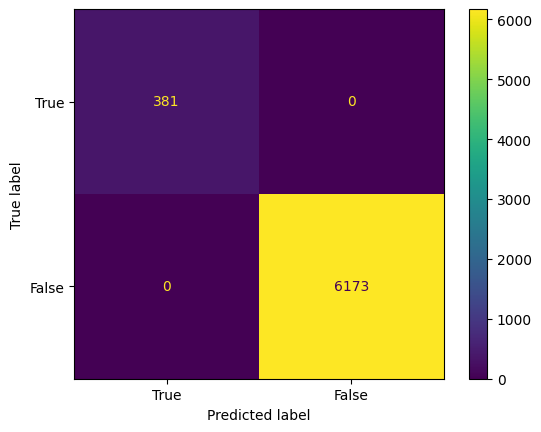

FPR: 0.0 TPR: 1.0


In [6]:
from sklearn import metrics
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:",cm)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [True, False])
cm_display.plot()
plt.savefig('/kaggle/working/xception_cm.png')
plt.show()

fpr_cm = cm[0, 1] / (cm[0, 1] + cm[0, 0])
tpr_cm = cm[1, 1] / (cm[1, 1] + cm[1, 0])

print("FPR:", fpr_cm, "TPR:", tpr_cm)

ROC: 1.0


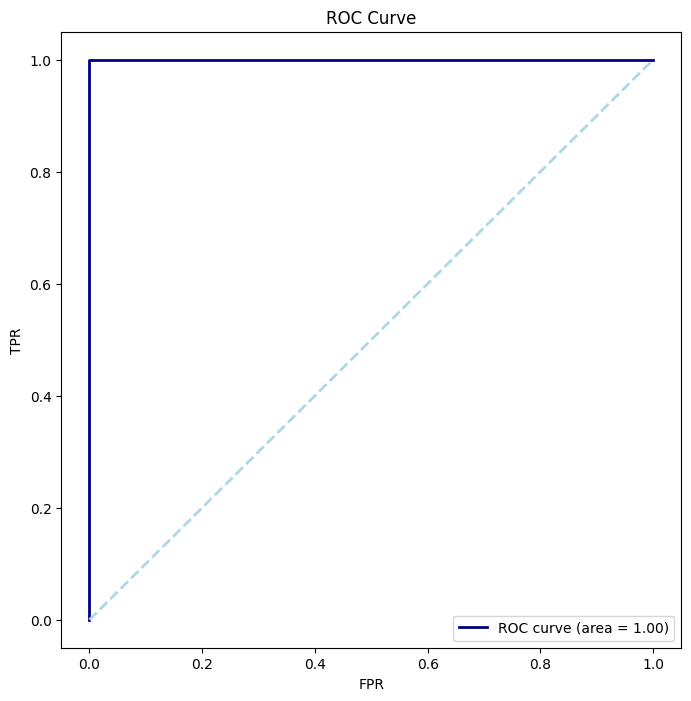

In [7]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print("ROC:",roc_auc)

plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='navy', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='lightblue', lw=2, linestyle='--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.savefig('/kaggle/working/xception_roc.png')
plt.show()

PRC: 1.0


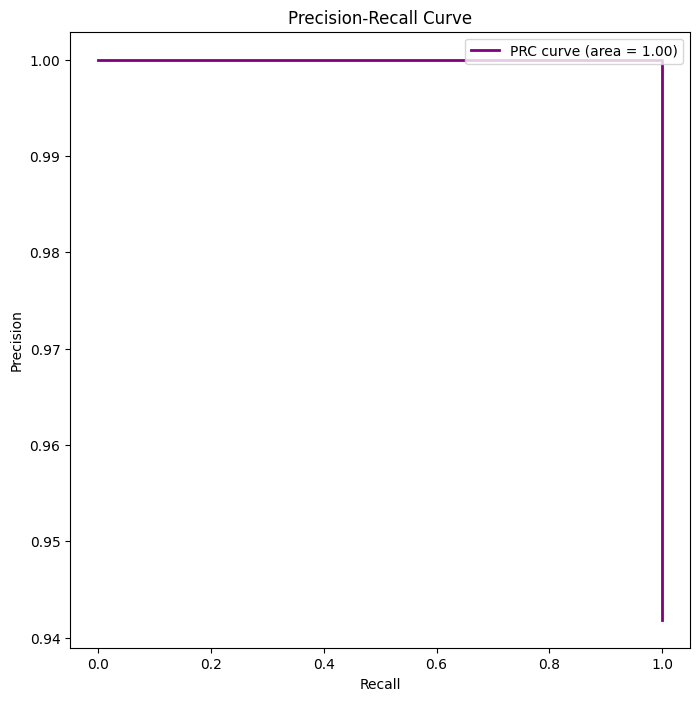

In [8]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
prc_auc = auc(recall, precision)
print("PRC:",prc_auc)

plt.figure(figsize=(8, 8))
plt.plot(recall, precision, color='purple', lw=2, label='PRC curve (area = {:.2f})'.format(prc_auc))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='upper right')
plt.savefig('/kaggle/working/xception_prc.png')
plt.show()

In [9]:
f1_score_value = f1_score(y_test, y_pred, average='macro')
recall_score_value = recall_score(y_test, y_pred, average='macro')
precision_score_value = average_precision_score(y_test, y_pred, average = 'macro')

print("F1 score:",f1_score_value,"recall score:", recall_score_value, "precision score:", precision_score_value)

F1 score: 1.0 recall score: 1.0 precision score: 1.0


In [10]:
print(fpr)
print(tpr)
print(precision)
print(recall)

[0. 0. 1.]
[0. 1. 1.]
[0.94186756 1.         1.        ]
[1. 1. 0.]


In [11]:
print(fpr_cm)
print(tpr_cm)
print(precision_score_value)
print(recall_score_value)

0.0
1.0
1.0
1.0


In [12]:
all_scores= {
    'F1 Score': f1_score_value,
    'Recall value': recall_score_value,
    'Precision value': precision_score_value,
    'FPR value': fpr_cm,
    'TPR value': tpr_cm,
    'FPR list' : fpr,
    'TPR list': tpr,
    'Recall list':recall,
    'Precision list':precision,
    'ROC AUC': roc_auc,
    'PRC AUC': prc_auc
    }
print('F1 Score:', f1_score_value)
print('Recall value:', recall_score_value)
print('FPR value:', fpr_cm)
print('TPR value:', tpr_cm)
print('ROC AUC:', roc_auc)
print('PRC AUC:', prc_auc)
print('All Scores:', all_scores)

F1 Score: 1.0
Recall value: 1.0
FPR value: 0.0
TPR value: 1.0
ROC AUC: 1.0
PRC AUC: 1.0
All Scores: {'F1 Score': 1.0, 'Recall value': 1.0, 'Precision value': 1.0, 'FPR value': 0.0, 'TPR value': 1.0, 'FPR list': array([0., 0., 1.]), 'TPR list': array([0., 1., 1.]), 'Recall list': array([1., 1., 0.]), 'Precision list': array([0.94186756, 1.        , 1.        ]), 'ROC AUC': 1.0, 'PRC AUC': 1.0}


In [13]:
output_file_path = '/kaggle/working/xception_amazon_no_smote.txt'
with open(output_file_path, 'w') as f: 
    f.write(": {}\n".format(all_scores))

In [14]:
import json
dict_string = json.dumps(all_scores)
file_path = '/kaggle/working/output.txt'

with open(file_path, 'w') as file:
    file.write(dict_string)

scores_table = pd.DataFrame({
    'Metric': ['F1 Score', 'True Positive Rate', 'False Positive Rate'],
    'Score': [f1_score_value, tpr_cm, fpr_cm]
})
scores_table.to_csv('/kaggle/working/scores_table.csv', index=False)
print(scores_table)

TypeError: Object of type ndarray is not JSON serializable

In [ ]:
arrays_ = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred})
arrays_.to_csv('/kaggle/working/pred_array_output_file.csv', index=False)

In [ ]:
from tensorflow.keras.models import save_model
model.save('/kaggle/working/xception_model.h5')

In [ ]:
pr_arrays = pd.DataFrame({'tpr':tpr,'fpr':fpr})
pr_arrays.to_csv('/kaggle/working/pr_array_output.csv',index= False)

In [15]:


import json

# Assuming tpr and fpr are NumPy arrays
print("Type of f1:", type(f1_score_value))
print("Type of precision:", type(precision))
print("Type of recall:", type(recall))
print("Type of tpr_value:", type(tpr_cm))
print("Type of fpr_value:", type(fpr_cm))
print("Type of roc_auc:", type(roc_auc))
print("Type of prc_auc:", type(prc_auc))
print("Type of tpr:", type(tpr))
print("Type of fpr:", type(fpr))

precision_list = precision.tolist()
recall_list = recall.tolist()
tpr_list = tpr.tolist()
fpr_list = fpr.tolist()

#print(f1.type())

data = {
    "Average F1 Score": float(f1_score_value), 
    "Average Precision": float(precision_score_value), 
    "Average Recall": float(recall_score_value), 
    "Average True Positive Rate": float(tpr_cm), 
    "Average False Positive Rate": float(fpr_cm), 
    "Average ROC AUC": roc_auc, 
    "Average PRC AUC": prc_auc,
    "TPR Array" : tpr_list,
    "FPR Array" : fpr_list,
    "Precision Array": precision_list, 
    "Recall Array": recall_list
}

# Specify the file path
file_path = "/kaggle/working/Xception - Real PCA - Lenny.json"

# Write the data to a JSON file
with open(file_path, "w") as json_file:
    json.dump(data, json_file)

Type of f1: <class 'numpy.float64'>
Type of precision: <class 'numpy.ndarray'>
Type of recall: <class 'numpy.ndarray'>
Type of tpr_value: <class 'numpy.float64'>
Type of fpr_value: <class 'numpy.float64'>
Type of roc_auc: <class 'numpy.float64'>
Type of prc_auc: <class 'numpy.float64'>
Type of tpr: <class 'numpy.ndarray'>
Type of fpr: <class 'numpy.ndarray'>
